# Modelling a supervised reviews classification model



In [3]:
# Importing basic libraries 
import numpy as np
import pandas as pd
# Importing ML libraries 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import ComplementNB
import ast

Loading the merged dataset created in the first section of CorpusAnalysis.

In [4]:
df = pd.read_csv('filtered_merged_data.csv', dtype={'ownership_tier': pd.CategoricalDtype(categories=['Low', 'Medium', 'High'], 
                                                                                          ordered=True)},
                          converters={'tokens': ast.literal_eval,
                                      'filtered_tokens': ast.literal_eval})
df.dropna(subset=['filtered_tokens', 'score'], inplace=True)
df.head()

,Unnamed: 0.1,Unnamed: 0,id,app_id,content,author_id,score,name,average_owners,tokens,cleaned_content,ownership_tier,filtered_tokens
0,0,0,181398278,630,my friend fucking glitched out of the map. dud...,76561199715566328,0,Alien Swarm,3500000.0,"[friend, fucking, glitched, map, dude]",friend fucking glitched map dude,Low,"[friend, fucking, glitched, map, dude]"
1,1,1,175959006,630,nobody is playing this game,76561198880505482,0,Alien Swarm,3500000.0,"[nobody, playing, game]",nobody playing game,Low,[nobody]
2,2,2,175942905,630,this game isn't very fun it runs like ass and ...,76561199208923353,0,Alien Swarm,3500000.0,"[game, fun, run, like, as, community, ready, k...",game fun run like as community ready kick soon...,Low,"[run, as, community, ready, kick, soon, make, ..."
3,3,3,175501438,630,last mission was so hard,76561199229157735,0,Alien Swarm,3500000.0,"[last, mission, hard]",last mission hard,Low,"[last, mission, hard]"
4,4,4,170983852,630,As an avid fan of Alien Shooter 2 from its hey...,76561199687240931,0,Alien Swarm,3500000.0,"[avid, fan, alien, shooter, heyday, approached...",avid fan alien shooter heyday approached game ...,Low,"[avid, fan, alien, shooter, approached, high, ..."


In [5]:
X = df['filtered_tokens'].apply(lambda tokens: " ".join(tokens))
y = df['score']

# First split: train vs. (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.4,   # 40% goes into the temp set (val+test)
    random_state=42
)

# Second split: val vs. test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,   # Half of the temp set becomes test, other half val
    random_state=42
)

The first attempt is to fit a logistic regression model. To do so I first create a function that allows me to fit any preferred model through a pipeline without excessive code repetition. 

In [6]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def run_model_tuning(model, param_distributions, X_train, y_train, cv_folds=5, n_iter=25, scoring='accuracy'):
    """
    Helper function to build a TF-IDF pipeline, run hyperparameter tuning,
    and return the best estimator.
    """
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('model', model)
    ])
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    search = RandomizedSearchCV(pipeline,
                                param_distributions=param_distributions,
                                n_iter=n_iter,
                                scoring=scoring,
                                cv=cv,
                                verbose=2,
                                n_jobs=-1,
                                random_state=42)
    search.fit(X_train, y_train)
    print("Best Parameters:", search.best_params_)
    print(f"Best {scoring.capitalize()} Score:", search.best_score_)
    return search.best_estimator_


def plot_roc_curve(model, X_test, y_test, pos_label=1, title='ROC Curve', figsize=(8, 6)):
    """
    Plot the ROC curve for a binary classifier.

    Parameters:
    - model: A trained model or Pipeline that supports predict_proba or decision_function.
    - X_test: Test features.
    - y_test: True labels.
    - pos_label: The positive class label (default=1).
    - title: Title of the ROC plot.
    - figsize: Tuple specifying the figure size.
    """
    # Obtain predicted scores: try predict_proba; if not available, use decision_function.
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        raise ValueError("Model does not have predict_proba or decision_function method.")
    
    # Compute false positive rate, true positive rate, and thresholds.
    fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)
    
    # Plotting the ROC curve.
    plt.figure(figsize=figsize)
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    
    
def plot_learning_curve(estimator, X, y, cv, title="Learning Curve", n_jobs=-1):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y,
                                                            cv=cv,
                                                            n_jobs=n_jobs,
                                                            train_sizes=np.linspace(0.1, 1.0, 5),
                                                            scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation score')
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

In [112]:
# Using model tuning function to fit logistic regression
param_distributions_lr = {
    'tfidf__max_features': [1000, 2000, 4000, 6000, 10000],  # Vocabulary sizes
    'tfidf__ngram_range': [(1, 1), (1, 2)],                  # Unigrams and bigrams
    'tfidf__min_df': [1, 5, 10, 100],                         # Minimum document frequency
    'tfidf__max_df': [0.8, 0.9, 1.0],                         # Maximum document frequency
    'model__max_iter': [1000, 5000, 10000],               # Number of iterations for Logistic Regression
    'model__class_weight': ['balanced']
}

best_lr = run_model_tuning(LogisticRegression(class_weight='balanced', n_jobs=-1), param_distributions_lr, X_train, y_train, cv_folds=5)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Parameters: {'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 1, 'tfidf__max_features': 10000, 'tfidf__max_df': 0.8, 'model__max_iter': 1000, 'model__class_weight': 'balanced'}
Best Accuracy Score: 0.8503840600874891


In [113]:
# Predict on the validation set
y_pred_lr = best_lr.predict(X_val)

# Evaluate performance
print("Validation Set Accuracy:", accuracy_score(y_val, y_pred_lr))
print("Classification Report(Validation Set):\n", classification_report(y_val, y_pred_lr))

Validation Set Accuracy: 0.8530641934897254
Classification Report(Validation Set):
               precision    recall  f1-score   support

           0       0.71      0.81      0.76     21480
           1       0.92      0.87      0.90     55506

    accuracy                           0.85     76986
   macro avg       0.81      0.84      0.83     76986
weighted avg       0.86      0.85      0.86     76986



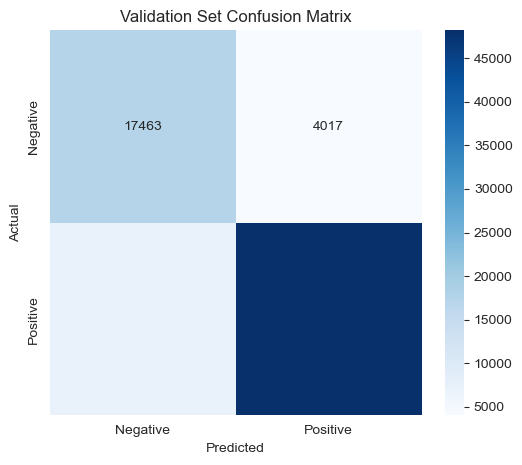

In [114]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# After predicting on the test set:
y_pred_test = best_lr.predict(X_test)
plot_confusion_matrix(y_val, y_pred_lr, classes=["Negative", "Positive"], title="Validation Set Confusion Matrix")

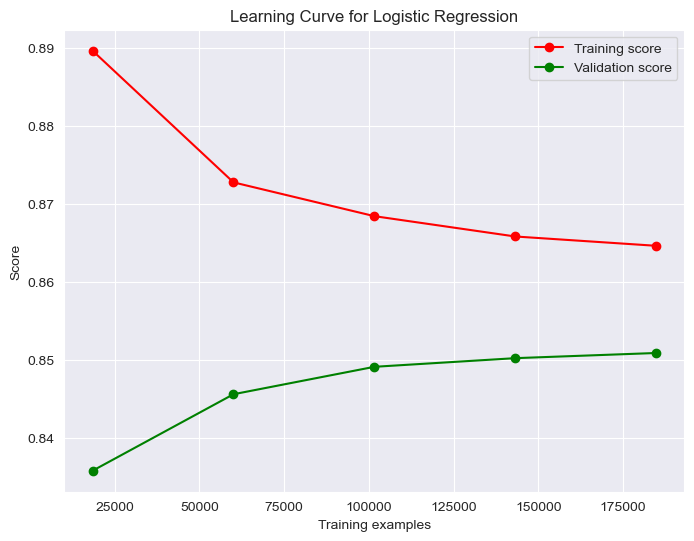

In [115]:
plot_learning_curve(best_lr, X_train, y_train, cv=5, title="Learning Curve for Logistic Regression")

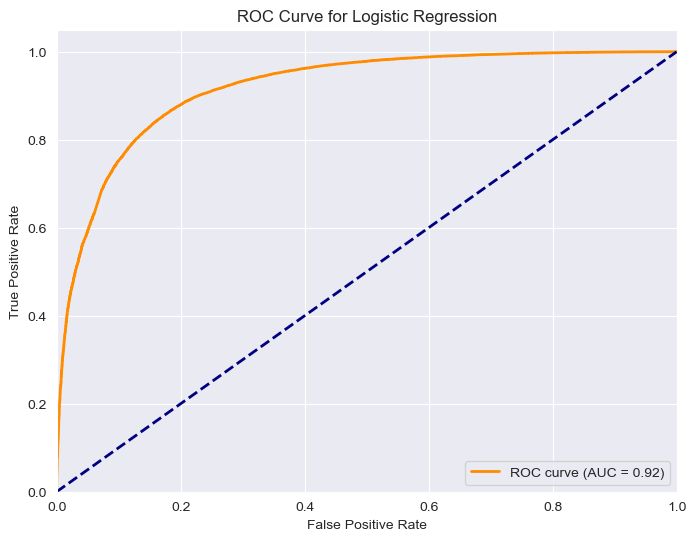

In [116]:
plot_roc_curve(best_lr, X_val, y_val, title="ROC Curve for Logistic Regression")

In [96]:
# Define parameter grid for TF-IDF and Complement Naive Bayes
param_distribution_cnb = {
    'tfidf__max_features': [1000, 5000, 10000],  # Vocabulary sizes
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Unigrams and bigrams
    'tfidf__min_df': [1, 5, 10],  # Minimum document frequency
    'model__alpha': [0.1, 0.5, 1.0, 10.0],  # Smoothing parameter
}
best_cnb = run_model_tuning(ComplementNB(), param_distribution_cnb, X_train, y_train, cv_folds=5)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Parameters: {'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 5, 'tfidf__max_features': 10000, 'model__alpha': 10.0}
Best Accuracy Score: 0.8015483346219767


In [97]:
# Predict on the validation set
y_pred_cnb = best_cnb.predict(X_val)

# Evaluate performance
print("Test Set Accuracy:", accuracy_score(y_val, y_pred_cnb))
print("Classification Report:\n", classification_report(y_val, y_pred_cnb))

Test Set Accuracy: 0.7997168316317252
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.79      0.69     21480
           1       0.91      0.80      0.85     55506

    accuracy                           0.80     76986
   macro avg       0.76      0.80      0.77     76986
weighted avg       0.82      0.80      0.81     76986



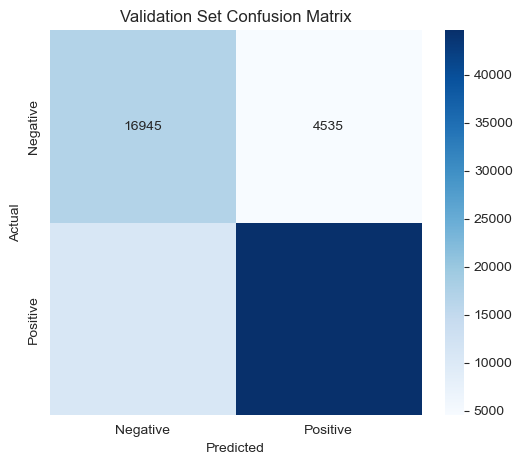

In [98]:
plot_confusion_matrix(y_val, y_pred_cnb, classes=["Negative", "Positive"], title="Validation Set Confusion Matrix")

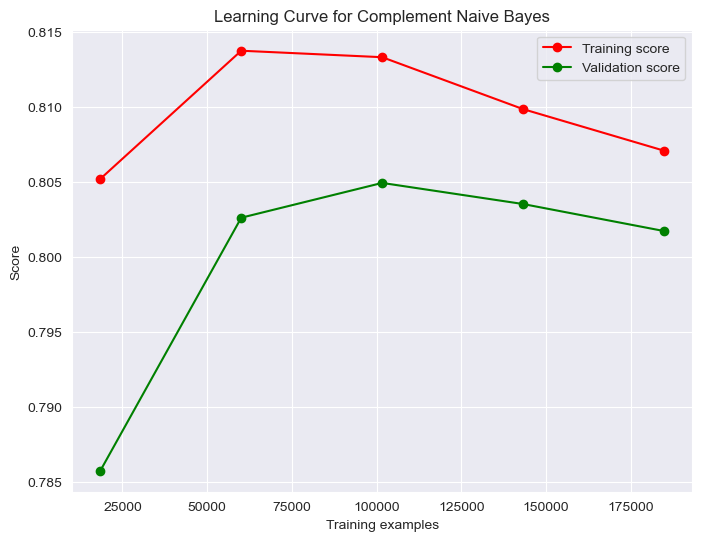

In [99]:
plot_learning_curve(best_cnb, X_train, y_train, cv=5, title="Learning Curve for Complement Naive Bayes")

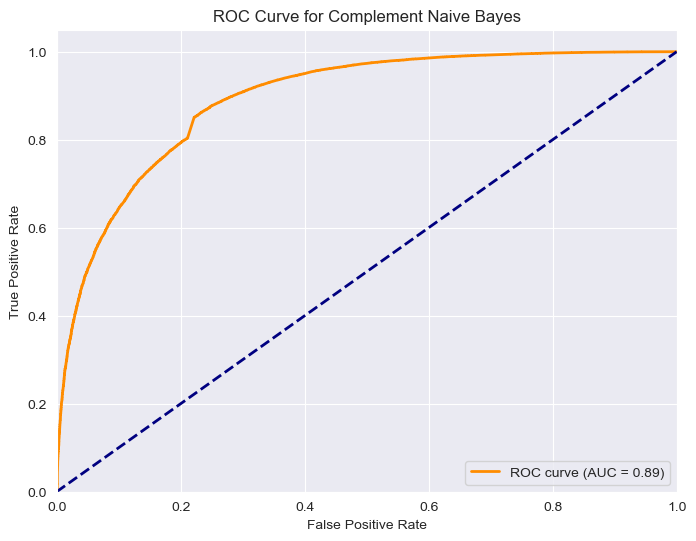

In [100]:
plot_roc_curve(best_cnb, X_val, y_val, title="ROC Curve for Complement Naive Bayes")

# Stochastic Gradient Descent Logistic Regression: a solution to sparse data


In [9]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score

# Define parameter grid for TF-IDF and SGDClassifier
param_grid_sgd = {
    'tfidf__max_features': [1000, 5000, 10000],  # Vocabulary sizes
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Unigrams and bigrams
    'tfidf__min_df': [1, 5],  # Minimum document frequency
    'model__alpha': [1e-4, 1e-3, 1e-2],  # Regularization strength
    'model__penalty': ['l2', 'l1', 'elasticnet'],  # Regularization types
    'model__max_iter': [1000, 5000, 10000],  # Iterations for convergence
    'model__eta0': [0.1, 0.01, 0.001]
}

best_sgd = run_model_tuning(SGDClassifier(loss='log_loss', n_jobs=-1), param_grid_sgd,X_train, y_train, cv_folds=5,n_iter=25, scoring='accuracy')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Parameters: {'tfidf__ngram_range': (1, 1), 'tfidf__min_df': 5, 'tfidf__max_features': 5000, 'model__penalty': 'l2', 'model__max_iter': 10000, 'model__eta0': 0.001, 'model__alpha': 0.0001}
Best Accuracy Score: 0.8406333667475503


In [10]:
# Predict on the validation set
y_pred_sgd = best_sgd.predict(X_val)

# Evaluate performance
print("Test Set Accuracy:", accuracy_score(y_val, y_pred_sgd))
print("Classification Report:\n", classification_report(y_val, y_pred_sgd))

Test Set Accuracy: 0.8428805237315876
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.53      0.65     21480
           1       0.84      0.96      0.90     55506

    accuracy                           0.84     76986
   macro avg       0.85      0.75      0.78     76986
weighted avg       0.84      0.84      0.83     76986



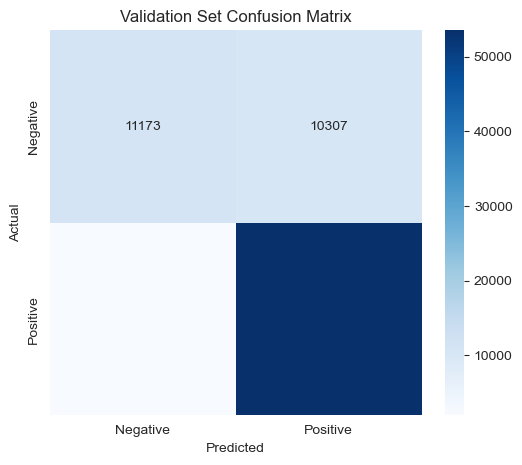

In [109]:
plot_confusion_matrix(y_val, y_pred_sgd, classes=["Negative", "Positive"], title="Validation Set Confusion Matrix")

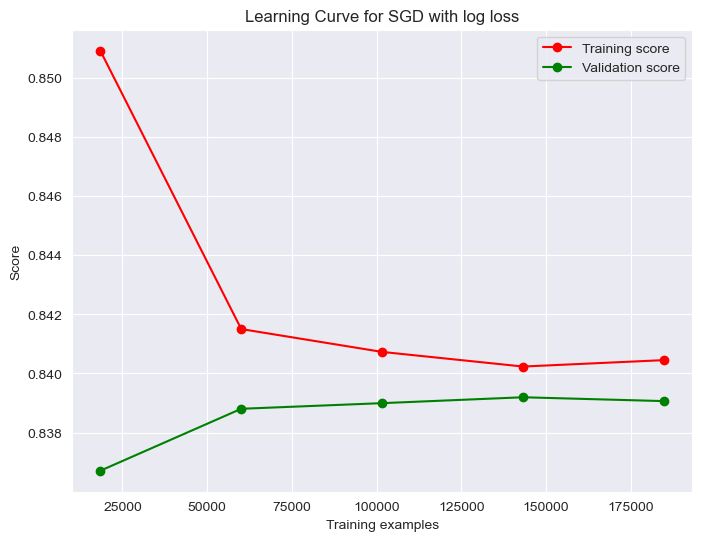

In [110]:
plot_learning_curve(best_sgd, X_train, y_train, cv=5, title="Learning Curve for SGD with log loss")

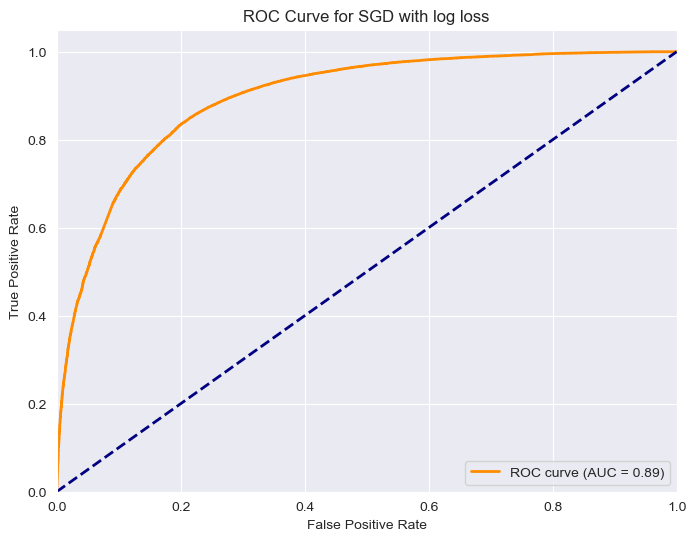

In [111]:
plot_roc_curve(best_sgd, X_val, y_val, title="ROC Curve for SGD with log loss")